## Is Augmentation Necessary?
In this notebook, we will check how the network trained on ordinary data copes with the augmented data and what will happen if it is learned from the augmented data.

How the implement class with the neural network you'll see in [this](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/Second_tutorial/simple_conv_model.py) file.

In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')
import utils
from tutorials.Second_tutorial.my_batch import MnistBatch
from tutorials.Second_tutorial.simple_conv_model import ConvModel
from dataset import V, B
from dataset.opensets import MNIST

Create batch class depended from MnistBatch

In [2]:
mnistset = MNIST(batch_class=MnistBatch)

ExtractingExtractingExtracting   /tmp/t10k-labels-idx1-ubyte.gz/tmp/train-images-idx3-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz


Extracting /tmp/train-labels-idx1-ubyte.gz


Already familiar to us the construction to create the pipelines. These pipelines train NN on simple MNIST images, without shift.

In [3]:
normal_train_ppl = (mnistset.train.p
                    .init_model('dynamic',
                                ConvModel,
                                'conv',
                                config={'inputs': dict(images={'shape': (28, 28, 1)},
                                                       labels={'classes': (10), 
                                                               'transform': 'ohe', 
                                                               'name': 'targets'}),
                                        'loss': 'softmax_cross_entropy',
                                        'optimizer':'Adam',
                                        'input_block/inputs': 'images',
                                        'head/units': 10,
                                        'output': dict(ops=['labels', 'proba', 'accuracy'])})
                    .train_model('conv',
                                 feed_dict={'images': B('images'),
                                            'labels': B('labels')}))

In [4]:
normal_test_ppl = (mnistset.test.p
                   .import_model('conv', normal_train_ppl)
                   .init_variable('test_accuracy', init_on_each_run=int)
                   .predict_model('conv', 
                                  fetches='accuracy',
                                  feed_dict={'images': B('images'),
                                             'labels': B('labels')},
                                  save_to=V('test_accuracy'), 
                                  mode='w'))

Train the model by using __next_batch__ method

In [5]:
batch_size = 400
for i in tqn(range(600)):
    normal_train_ppl.next_batch(batch_size, n_epochs=None)
    normal_test_ppl.next_batch(batch_size, n_epochs=None)

Get variable from pipeline and print accuracy on data without shift

In [6]:
acc = normal_test_ppl.get_variable('test_accuracy')
print('Accuracy on normal data: ', acc)

Accuracy on normal data:  0.98499995


Now check, how change accuracy, if the first model testing on shift data

In [7]:
shift_test_ppl= (mnistset.test.p
                 .import_model('conv', normal_train_ppl)
                 .shift_flattened_pic()
                 .init_variable('predict', init_on_each_run=int)
                 .predict_model('conv', 
                                fetches='accuracy',
                                feed_dict={'images': B('images'),
                                           'labels': B('labels')},
                                 save_to=V('predict'), 
                                 mode='w')
                 .run(batch_size, n_epochs=1))

In [8]:
print('Accuracy with shift: ',shift_test_ppl.get_variable('predict'))

Accuracy with shift:  0.45499995


In order for the model to be able to predict the augmentation data, we will teach it on such data

In [9]:
shift_train_ppl =  (mnistset.train.p
                    .shift_flattened_pic()
                    .init_model('dynamic',
                                ConvModel,
                                'conv',
                                config={'inputs': dict(images={'shape': (28, 28, 1)},
                                                       labels={'classes': (10), 
                                                               'transform': 'ohe', 
                                                               'name': 'targets'}),
                                        'loss': 'softmax_cross_entropy',
                                        'optimizer':'Adam',
                                        'input_block/inputs': 'images',
                                        'head/units': 10,
                                        'output': dict(ops=['labels', 'proba', 'accuracy'])})
                    .train_model('conv',
                                 feed_dict={'images': B('images'),
                                            'labels': B('labels')}))

In [10]:
for i in tqn(range(600)):
    shift_train_ppl.next_batch(batch_size, n_epochs=None)

And now check, how change accuracy on shift data

In [11]:
shift_test_ppl = (mnistset.test.p
                  .import_model('conv', shift_train_ppl)
                  .shift_flattened_pic()
                  .init_variable('acc', init_on_each_run=list)
                  .init_variable('img', init_on_each_run=list)
                  .init_variable('predict', init_on_each_run=list)
                  .predict_model('conv', 
                                 fetches=['accuracy', 'inputs', 'predicted_proba'],
                                 feed_dict={'images': B('images'),
                                            'labels': B('labels')},
                                 save_to=[V('acc'), V('img'), V('predict')],
                                 mode='a')
                  .run(1, n_epochs=1))

In [12]:
print('Accuracy with shift: ',np.mean(shift_test_ppl.get_variable('acc')))

Accuracy with shift:  0.7943


It's really better than before.

It is interesting, on what figures we are mistaken?

In [13]:
acc = shift_test_ppl.get_variable('acc')
img = shift_test_ppl.get_variable('img')
predict = shift_test_ppl.get_variable('predict')

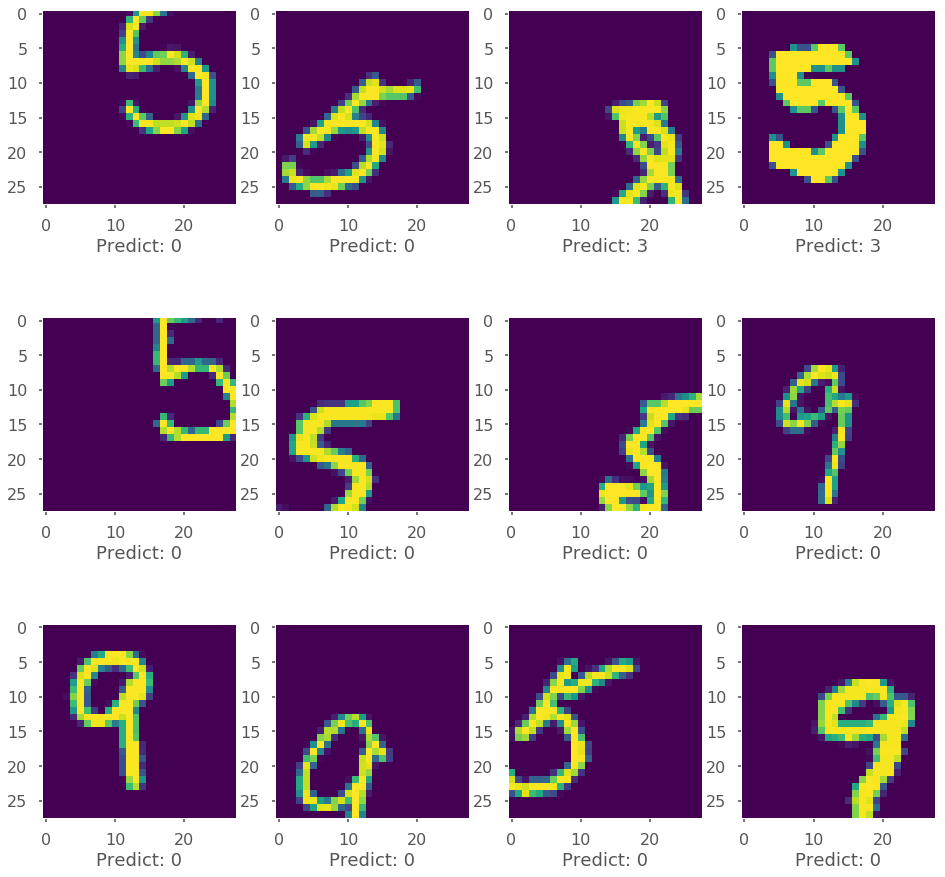

In [14]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)
for i in range(12):
    index = np.where(np.array(acc) == 0)[0][i]
    ax[i].imshow(img[index]['images'].reshape(-1,28))
    ax[i].set_xlabel('Predict: {}'.format(np.argmax(predict[index][0])), fontsize=18)
    ax[i].grid()

In most cases, the model is mistaken for examples in which the figures are heavily shifted, some of them are even hardly recognizable by eye.

### Сonclusion:
* The network is not trained on the augmented data can not predict such figures with good quality. Therefore training on augmentation data are necessary.

If you still have not completed our tutorial, you can fix it right [now](https://github.com/analysiscenter/az_training/tree/master/anton_broilovskiy/tutorials/First_tutorial/Dataset.ipynb)!
### Other reuearch:
* ResNet with [stochastic depth](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/stochastic_depth/stochastic_depth.ipynb)
* Experiments with [weights](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/zeroing_of_weights/zeroing_of_weights.ipynb)
* [FreezeOut](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/freezeout/freezeout.ipynb)
* [Squeeze and excitation](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/squeeze_and_excitation/squeeze_and_excitation.ipynb) block in ResNet